In [1]:
# This R environment comes with many helpful analytics packages installed
# It is defined by the kaggle/rstats Docker image: https://github.com/kaggle/docker-rstats
# For example, here's a helpful package to load

library(tidyverse) # metapackage of all tidyverse packages

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

list.files(path = "../input")

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.4     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



[1] "factors-affecting-campus-placement"

loading data:

In [2]:
library('funModeling') 
library('Hmisc')
library('dummies')
library('corrplot')
library('gmodels')
library('class')
library('dummies')
library('tidyr')

Loading required package: Hmisc

Loading required package: lattice

Loading required package: survival

Loading required package: Formula


Attaching package: ‘Hmisc’


The following objects are masked from ‘package:dplyr’:

    src, summarize


The following objects are masked from ‘package:base’:

    format.pval, units


funModeling v.1.9.4 :)
Examples and tutorials at livebook.datascienceheroes.com
 / Now in Spanish: librovivodecienciadedatos.ai

dummies-1.5.6 provided by Decision Patterns


corrplot 0.84 loaded



In [3]:
data <- read.csv(("../input/factors-affecting-campus-placement/Placement_Data_Full_Class.csv"))

data cleaning:

* We can see there are some missing values at the salary column, corresponding to the students that weren't placed.Since we are interested on predicting the student's placement we drop the columns sl_no and salary provide no interest to us.

* transformation of categorical data

* normilization

In [4]:

#Dropping sl_no column and salary columns
data = data[,!names(data) %in% 'sl_no']
data = data[,!names(data) %in% 'salary']
data[data==''] <- NA #To make sure missing data is NA

In [5]:
#First we need to transform all our categorical variables (apart from our target variable: status) into numerical by creating dummy bolooen columns.
categorical = c('gender','hsc_s','ssc_b','hsc_b','ssc_s','degree_t','workex','specialisation')
results <- fastDummies::dummy_cols(data, select_columns = categorical) #creating the dummy columns
res <- results[, !(names(results) %in% categorical)] #deleting initial columns

Warning message in fastDummies::dummy_cols(data, select_columns = categorical):
“NOTE: The following select_columns input(s) is not a column in data.
	”


In [6]:
#Afterwards we need to normalize the quantitative variables to express them in the same range of values.

#Normalize() funciton
normalize <- function(x) {
num <- x - min(x)
denom <- max(x) - min(x)
return (num/denom)
}

# Normalize our placement dataset
plac_norm <- as.data.frame(lapply(res[,c(1:5,7:22)], normalize)) #all columns apart from status (column 6)

spliting dataset:

In [7]:
#Then we split the data set into two: a training set(2/3) and a test set(1/3). The first is used to train the model, while the second is used to evaluate the trained model.

set.seed(1234)
#Training set will be 2/3 of original data set
ind <- sample(2, nrow(plac_norm), replace=TRUE, prob=c(0.666, 0.334))

plac.training <- plac_norm[ind == 1,]
plac.test <- plac_norm[ind == 2,]

In [8]:
#Creating a vector for each train/test dataset with our target variable "status".

plac.trainLabels <- res[ind==1,6] #column 6 is our target.
plac.testLabels <- res[ind==2,6]

KNN approach:

In [9]:
#Now we want to find the k nearest neighbors of our training set.

#We will be using the knn() function, which uses the Euclidian distance measure in order to find the k-nearest neighbors to our new, unknown instance. Here, k parameter needs to be set.

# Execution of k-NN with k = 1
knn_1 <- knn(plac.training, plac.test, plac.trainLabels, k=1, prob = TRUE)

# Execution of k-NN with k = 2
knn_2 <- knn(plac.training, plac.test, plac.trainLabels, k=2, prob = TRUE)

To evaluate our model we will use a confusion matrix and the calculated model accuracy with different values of k to study which one offers the best result.

In [10]:
# Accuracy of KnnTestPrediction for k = 1
round(sum(knn_1==plac.testLabels)/length(plac.testLabels)*100,2)


# Confusion matrix of KnnTestPrediction for k = 1
cm <- table(plac.testLabels, knn_1)

# Precision of KnnTestPrediction for k = 1 of False Posites
round((cm[2,2]/(cm[2,2]+cm[2,1]))*100,2)

cm

[1] 65.08

[1] 73.81

               knn_1
plac.testLabels Not Placed Placed
     Not Placed         10     11
     Placed             11     31

We can interpret the matrix:

10 of the 21 students in the test data are correctly predicted as "Not Placed", whereas the reamining 11 are misclassified;
31 of the 42 students in the test data are correctly predicted as "Placed" and 11 are misclassfied.
giving an accuracy of 65.08%
giving a precision of 73.81%
The model is doing a decent job predicting students to be placed (which is what we are most interested on) but doing a bad job on identifying students that weren't placed.

On the run below with a k = 2 the model accuracy is the same, but it is doing a worse job since it decreased the number predicted "Placed" students, meaning that is increasing the "False Positives".
Our goal is to correctly predict the students that will be placed and maxime the precision

In [11]:
# Accuracy of KnnTestPrediction for k = 2
round(sum(plac.testLabels==knn_2)/length(plac.testLabels)*100,2)

# Confusion matrix of KnnTestPrediction for k = 2
cm <- table(plac.testLabels, knn_2)

round((cm[2,2]/(cm[2,2]+cm[2,1]))*100,2)

cm

[1] 65.08

[1] 71.43

               knn_2
plac.testLabels Not Placed Placed
     Not Placed         11     10
     Placed             12     30

To graphically show which values of k give us the best classification, we can plot "Accuracy vs k number of Neighbors"

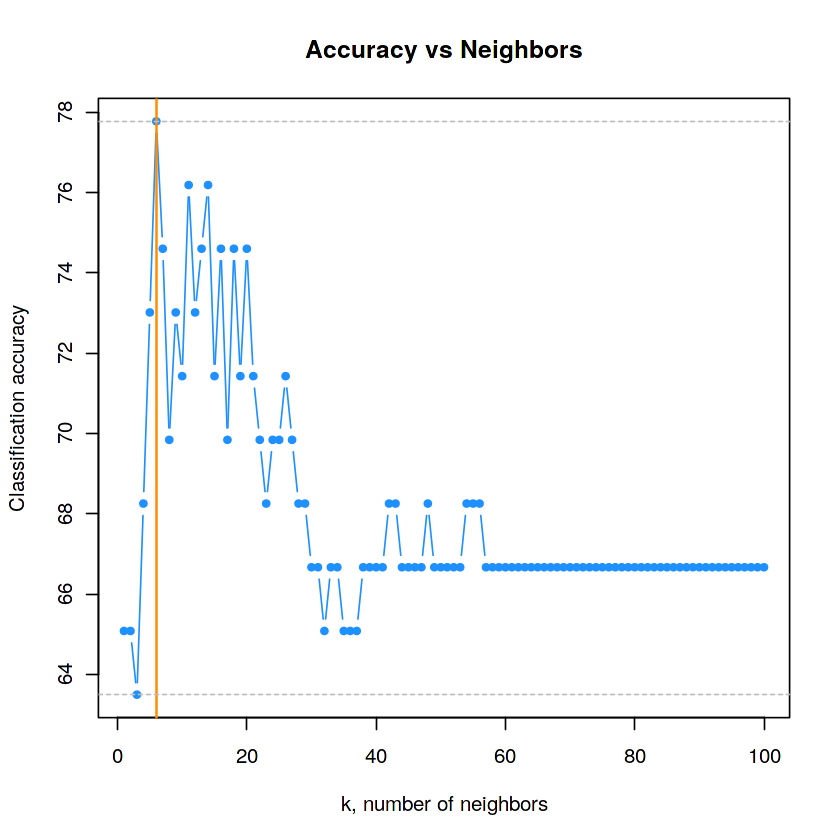

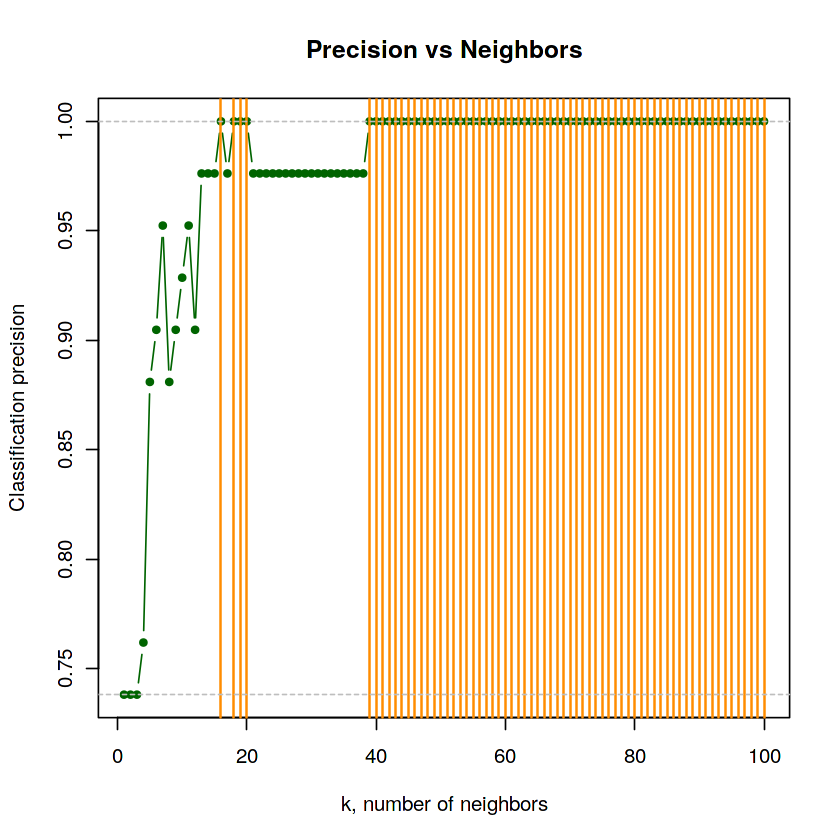

In [12]:
# Creating the variables
KnnTestPrediction <- list()
accuracy <- numeric()
precision <- numeric()

# Simulating from k=1 to k=100...
for(k in 1:100){

  # KnnTestPrediction for each k
  KnnTestPrediction[[k]] <- knn(plac.training, plac.test, plac.trainLabels, k, prob=TRUE)
    
  # Accuracy for each k   
  accuracy[k] <- sum(KnnTestPrediction[[k]]==plac.testLabels)/length(plac.testLabels)*100
  
  #Precision for each k
  precision[k] <- sum(KnnTestPrediction[[k]]=="Placed" & plac.testLabels=="Placed")/(sum((plac.testLabels=="Placed")))
}

# Accuracy vs number of k
plot(accuracy, type="b", col="dodgerblue", cex=1, pch=20,
     xlab="k, number of neighbors", ylab="Classification accuracy", 
     main="Accuracy vs Neighbors")

# line for k with best accuracy
abline(v=which(accuracy==max(accuracy)), col="darkorange", lwd=1.5)

# line for max accuracy seen
abline(h=max(accuracy), col="grey", lty=2)

# line for min accuracy seen
abline(h=min(accuracy), col="grey", lty=2)


# Accuracy vs number of k
plot(precision, type="b", col="darkgreen", cex=1, pch=20,
     xlab="k, number of neighbors", ylab="Classification precision", 
     main="Precision vs Neighbors")

# line for k with best precision
abline(v=which(precision==max(precision)), col="darkorange", lwd=1.5)

# line for max accuracy seen
abline(h=max(precision), col="grey", lty=2)

# line for min accuracy seen
abline(h=min(precision), col="grey", lty=2)

In [13]:
# Execution of k-NN with k = 6
knn <- knn(plac.training, plac.test, plac.trainLabels, k=6, prob = TRUE)

# Accuracy of KnnTestPrediction for k = 6
round(sum(plac.testLabels==knn)/length(plac.testLabels)*100,2)

#Precision of KnnTestPrediction for k = 6

round(sum(plac.testLabels == "Placed" & knn == "Placed")/sum((plac.testLabels=="Placed")),2)

# Confusion matrix of KnnTestPrediction for k = 6
table(plac.testLabels, knn)

[1] 71.43

[1] 0.9

               knn
plac.testLabels Not Placed Placed
     Not Placed          7     14
     Placed              4     38

To reach the maximum accuracy with this model the k value is 6. The model is doing a great job with a high accuracy and only mispredicting very few "Placed" student.

We could achieve higher precision of 100% with k > 14 but we could be suffering from overfitting our data.